In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import json
from PIL import Image
import glob
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import os
os.chdir(caffe_root)
import sys
sys.path.insert(0, 'python')
sys.path.append("/Users/marissac/Documents/COCOText/coco-text-master")
import caffe
import coco_text
import coco_evaluation
import skimage.io as io
import cv2
import math

CAFFE_LABEL_TO_CHAR_MAP = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5',
    6: '6',
    7: '7',
    8: '8',
    9: '9',
    10: 'a',
    11: 'b',
    12: 'c',
    13: 'd',
    14: 'e',
    15: 'f',
    16: 'g',
    17: 'h',
    18: 'i',
    19: 'j',
    20: 'k',
    21: 'l',
    22: 'm',
    23: 'n',
    24: 'o',
    25: 'p',
    26: 'q',
    27: 'r',
    28: 's',
    29: 't',
    30: 'u',
    31: 'v',
    32: 'w',
    33: 'x',
    34: 'y',
    35: 'z',
    36: ' ',
    37: '\0',
    38: '\0'
}


#caffe.set_device(0)
#caffe.set_mode_cpu()

from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL COCO labels
coco_labelmap_file = '/Users/marissac/caffe/data/coco/labelmap_coco_combo.prototxt'
#coco_labelmap_file = '/Users/marissac/caffe/data/coco/labelmap_cocoText.prototxt'
file = open(coco_labelmap_file, 'r')
coco_labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), coco_labelmap)

def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    print num_labels
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

icdar_dataset = "icdar-2011"
data_type = "train-textloc"

anno_dir = "/Users/marissac/data/ICDAR/" + icdar_dataset + "/" + data_type + "/"
out_dir = "/Users/marissac/data/ICDAR/" + icdar_dataset + "/" + data_type + "-output"

fileNames = glob.glob(anno_dir + '*.jpg')
numFiles = len(fileNames)



model_def = '/Users/marissac/caffe/models/VGGNet/cocoText/SSD_300x300/deploy_digitIn_multiclass.prototxt'
model_weights = '/Users/marissac/caffe/examples/ssd/models/VGGNet/cocoText/SSD_300x300/VGG_cocoText_SSD_300x300_multiclass_iter_120000.caffemodel'

#model_def = '/Users/marissac/caffe/models/VGGNet/cocoText/SSD_300x300/deploy_selectDigit.prototxt'
#model_weights = '/Users/marissac/caffe/examples/ssd/models/VGGNet/cocoText/SSD_300x300/VGG_cocoText_SSD_300x300_iter_140000.caffemodel'

synth_model = '/Users/marissac/caffe/examples/ocr/90ksynth/deploy_2.prototxt'
synth_model_weights = '/Users/marissac/caffe/examples/ocr/90ksynth/90ksynth_v2_v00_iter_140000.caffemodel'
net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)
net_synth = caffe.Net(synth_model,
                     synth_model_weights,
                     caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB


mean_blob = caffe.proto.caffe_pb2.BlobProto()
data_use = open('/Users/marissac/caffe/examples/ocr/90ksynth/90ksynth_leveldb_mean.binaryproto','rb').read()
mean_blob.ParseFromString(data_use)
mean_arr = np.array( caffe.io.blobproto_to_array(mean_blob) )
mean_val = np.mean(mean_arr)
print mean_val
#synth_transformer = caffe.io.Transformer({'data': (1, 1, 32, 100)})  # pylint: disable=invalid-name
#synth_transformer.set_mean('data', np.array([mean_val]))
#synth_transformer.set_input_scale('data', 1.0 / 256.0)

synth_transformer = caffe.io.Transformer({'data': net_synth.blobs['data'].data.shape})
synth_transformer.set_transpose('data', (2, 0, 1))
synth_transformer.set_mean('data', np.array([mean_val])/256.0)

imgSize = 300

ct = coco_text.COCO_Text()

118.088144832


In [4]:
# Select a random file

file_id_use = np.random.randint(0,numFiles)
#file_id_use = 65
fileNameTemp = fileNames[file_id_use]
# Find the image id from the filename
fileNameTemp = fileNameTemp.rstrip('.jpg')
fileNameTemp = fileNameTemp[len(anno_dir):]
img_id = int(fileNameTemp)
img_file_name = repr(img_id) + '.jpg'
thresh_use = 0.15

image = caffe.io.load_image('%s/%s'%(anno_dir,img_file_name))

# Load annotations
name = icdar_dataset + "_" + repr(img_id)  
anno_file = "{}/{}.json".format(out_dir, name)
json_data = open(anno_file)
anno_data = json.load(json_data)

anns = anno_data['annotation']
ct.anns = anns
ct.imgToAnns[img_id] = list(np.linspace(0,len(anns)-1,len(anns)))

image_resize = 300
net.blobs['data'].reshape(1,3,image_resize,image_resize)

transformed_image = transformer.preprocess('data',image)
net.blobs['data'].data[...] = transformed_image
#net.blobs['data'].data[...] = test_image
# Forward pass.
net.forward()

detections = net.blobs['detection_out'].data

# Parse the outputs.
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]


#l = [det_label.index(i) for i in det_label if 82 in i]
class_indices = [i for i, label in enumerate(det_label) if label == 73]
class_conf = det_conf[class_indices]
class_label = det_label[class_indices]
class_xmin = det_xmin[class_indices]
class_ymin = det_ymin[class_indices]
class_xmax = det_xmax[class_indices]
class_ymax = det_ymax[class_indices]

top_indices = [i for i, conf in enumerate(class_conf) if conf > thresh_use]
print top_indices
top_conf = class_conf[top_indices]
top_label_indices = class_label[top_indices].tolist()
top_labels = get_labelname(coco_labelmap, top_label_indices)
top_xmin = class_xmin[top_indices]
top_ymin = class_ymin[top_indices]
top_xmax = class_xmax[top_indices]
top_ymax = class_ymax[top_indices]

num_detect = top_conf.shape[0]
detections = coco_text.COCO_Text()
detections.anns = {}
detections.imgToAnns[img_id] = []
for i in range(0,num_detect):
    xmin_pix = top_xmin[i] * image.shape[1]
    ymin_pix = top_ymin[i] * image.shape[0]
    width_pix = top_xmax[i] * image.shape[1] - xmin_pix
    height_pix = top_ymax[i] * image.shape[0] - ymin_pix
    area_pix = width_pix*height_pix
    category_id = 1
    id_use = i
    image_id = img_id
    score_use = top_conf[i]
    detections.anns[i] = {'area':area_pix,'bbox':[xmin_pix,ymin_pix,width_pix,height_pix],'category_id':category_id,
                          'id':id_use,'image_id':image_id,'score':score_use}
    detections.imgToAnns[img_id].append(i)

print detections.imgToAnns[img_id]
#our_results_reduced = coco_evaluation.reduceDetections(detections, confidence_threshold = thresh_use)
detection_img = coco_evaluation.getDetections(ct,detections,imgIds = [img_id],detection_threshold = 0.5)
print detection_img['true_positives']

[0, 1, 2, 3, 4, 5]
82
[0, 1, 2, 3, 4, 5]
[{'eval_id': 4, 'gt_id': 0.0}, {'eval_id': 0, 'gt_id': 4.0}, {'eval_id': 1, 'gt_id': 5.0}]


3
(1, 32, 100)
nzbb                   
(1, 32, 100)
herlip                 
(1, 32, 100)
desk                   


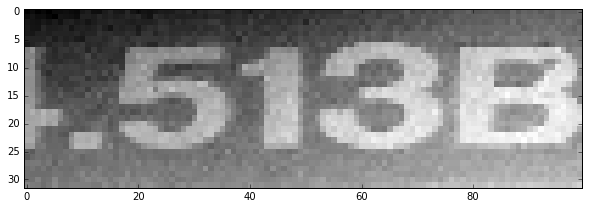

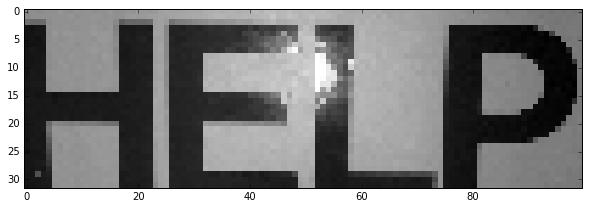

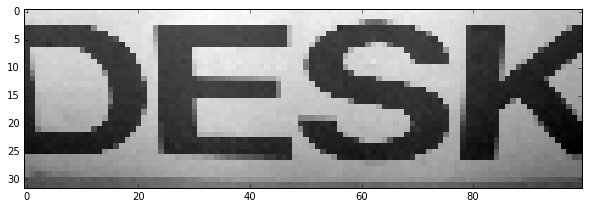

In [5]:
# Perform text reading for just the true positive detections associated with legible and english ground truth
true_detections = detection_img['true_positives']
new_width = 100
new_height =32
num_true_detect = len(true_detections)
img_shape = image.shape

gray_img = np.empty((img_shape[0],img_shape[1],1))
gray_img_temp = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray_img[:,:,0] = gray_img_temp
#plt.figure(0)
#plt.imshow(gray_img[:,:,0])
pix_change = 0
runFor = 1
print num_true_detect

for i in range(0,num_true_detect):

        # Get the bounding box associated with the detection
        detect_id = true_detections[i]['eval_id']
        
        detect_ann_temp = detections.anns[detect_id]
        bbox_use = detect_ann_temp['bbox']
        text_img = gray_img[int(math.floor(bbox_use[1]-pix_change)):int(math.ceil(bbox_use[1]+bbox_use[3]+pix_change)),
                            int(math.floor(bbox_use[0]-pix_change)):int(math.ceil(bbox_use[0]+bbox_use[2]+pix_change))]
        #gray_img = cv2.cvtColor(text_img, cv2.COLOR_BGR2GRAY)
        
        synth_transform_image = synth_transformer.preprocess('data',text_img)
        print synth_transform_image.shape
        #plt.figure(i+1)
        #plt.imshow(text_img[:,:,0])
        net_synth.blobs['data'].data[0,0,:,:] = synth_transform_image[0,:,:]

        net_synth.forward()
        output = net_synth.blobs['reshape'].data
        text_out = np.reshape(output,(39,23))
        text_max = np.argmax(text_out, axis=0) 
        plt.figure(i+1)
        plt.imshow(synth_transform_image[0,:,:])
        output_word = ''
        for j in range(0,23):
            output_word = output_word + CAFFE_LABEL_TO_CHAR_MAP[text_max[j]-1]
            
        detections.anns[detect_id]['utf8_string'] = output_word.strip()
        print output_word

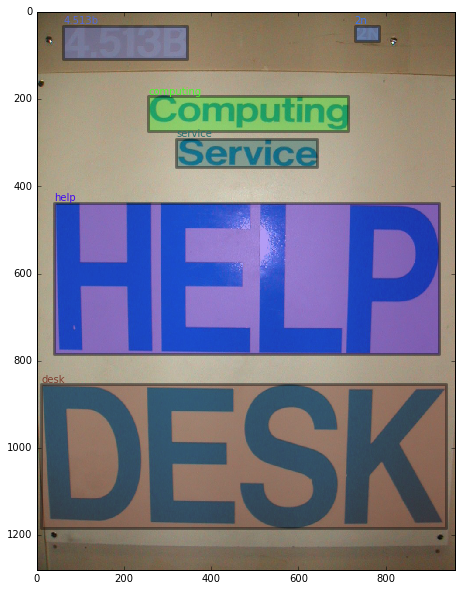

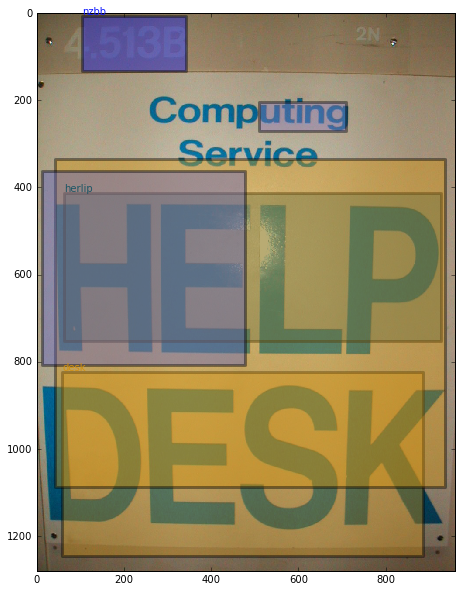

In [6]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
plt.figure()
plt.imshow(image)
ct.showAnns(anns)

detect_annIds = detections.getAnnIds(imgIds=img_id)        
detect_anns = detections.loadAnns(detect_annIds)
plt.figure()
plt.imshow(image)
ct.showAnns(detect_anns)

In [39]:
print file_id_use 

65
